In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
CSV_1 = './Data/mitbih_train.csv'
CSV_2 = './Data/mitbih_test.csv'

mit_train = pd.read_csv(CSV_1, header=None)
mit_test = pd.read_csv(CSV_2, header=None)

In [3]:
mit_train[187] = mit_train[187].astype('int64')

mit_test[187] = mit_test[187].astype('int64')

In [4]:
from imblearn.over_sampling import RandomOverSampler

data = mit_train.iloc[:, :187]
labels = mit_train.iloc[:, 187]

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample the data
data_resampled, labels_resampled = ros.fit_resample(data, labels)

train_df = pd.concat([data_resampled, labels_resampled], axis=1)

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train_df.iloc[:, :187],
                                                train_df.iloc[:, 187],
                                                test_size= 0.2,
                                                stratify=train_df.iloc[:, 187],
                                                random_state=42)

x_test = mit_test.iloc[:, :187]
y_test = mit_test.iloc[:, 187]

In [6]:
x_train = x_train.values
x_val = x_val.values
x_test = x_test.values

In [7]:
x_train = x_train.reshape(x_train.shape[0], -1, 1)
x_val = x_val.reshape(x_val.shape[0], -1, 1)
x_test = x_test.reshape(x_test.shape[0], -1, 1)

In [8]:
import tensorflow as tf

# Converts a class vector (integers) to binary class matrix (one hot encoder).

y_train = tf.keras.utils.to_categorical(y_train)

y_val = tf.keras.utils.to_categorical(y_val)

y_test = tf.keras.utils.to_categorical(y_test)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, MaxPool1D, Flatten, Dense, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [12]:
model_cnn_bilstm = Sequential([
    Input(shape=(x_train.shape[1:])),
    
    Conv1D(filters=151, kernel_size=1, activation='relu'),
    MaxPool1D(pool_size=2, strides=2),
    
    Conv1D(filters=101, kernel_size=1, activation='relu'),
    MaxPool1D(pool_size=2, strides=2),
    
    Conv1D(filters=51, kernel_size=1, activation='relu'),
    MaxPool1D(pool_size=2, strides=2),

    Bidirectional(LSTM(64, return_sequences=True, activation="tanh")),
    Bidirectional(LSTM(32, activation="tanh")),
    
    Flatten(),
    
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

In [13]:
model_cnn_bilstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 187, 151)            │             302 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 93, 151)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 93, 101)             │          15,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 46, 101)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 46, 51)              │           5,202 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 23, 51)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 23, 128)             │          59,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 127,869 (499.49 KB)

 Trainable params: 127,869 (499.49 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model_cnn_bilstm.compile(optimizer='adam',
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [15]:
callbacks = [EarlyStopping(monitor='val_loss', 
                           patience=8),
             ReduceLROnPlateau(patience=20,
                               monitor='val_loss',
                               min_lr=1e-6,
                               cool_down=20),
             ModelCheckpoint(filepath='best_model_cnn_bilstm.keras', 
                             monitor='val_loss',
                             save_best_only=True)]

In [16]:
history = model_cnn_bilstm.fit(x_train, y_train, 
                        epochs=10, 
                        callbacks=callbacks, 
                        batch_size=32, 
                        validation_data=(x_val, y_val),
                       verbose=1)

Epoch 1/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 278s 30ms/step - accuracy: 0.7492 - loss: 0.6438 - val_accuracy: 0.9308 - val_loss: 0.1923 - learning_rate: 0.0010
Epoch 2/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 263s 29ms/step - accuracy: 0.9383 - loss: 0.1720 - val_accuracy: 0.9630 - val_loss: 0.1060 - learning_rate: 0.0010
Epoch 3/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 273s 30ms/step - accuracy: 0.9640 - loss: 0.1038 - val_accuracy: 0.9719 - val_loss: 0.0830 - learning_rate: 0.0010
Epoch 4/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 274s 30ms/step - accuracy: 0.9748 - loss: 0.0743 - val_accuracy: 0.9791 - val_loss: 0.0629 - learning_rate: 0.0010
Epoch 5/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 262s 29ms/step - accuracy: 0.9795 - loss: 0.0599 - val_accuracy: 0.9789 - val_loss: 0.0622 - learning_rate: 0.0010
Epoch 6/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 264s 29ms/step - accuracy: 0.9834 - loss: 0.0500 - val_accuracy: 0.9853 - val_loss: 0.0465 - learning_rate: 0.0010
Epoch 7/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 267s 29ms/step -

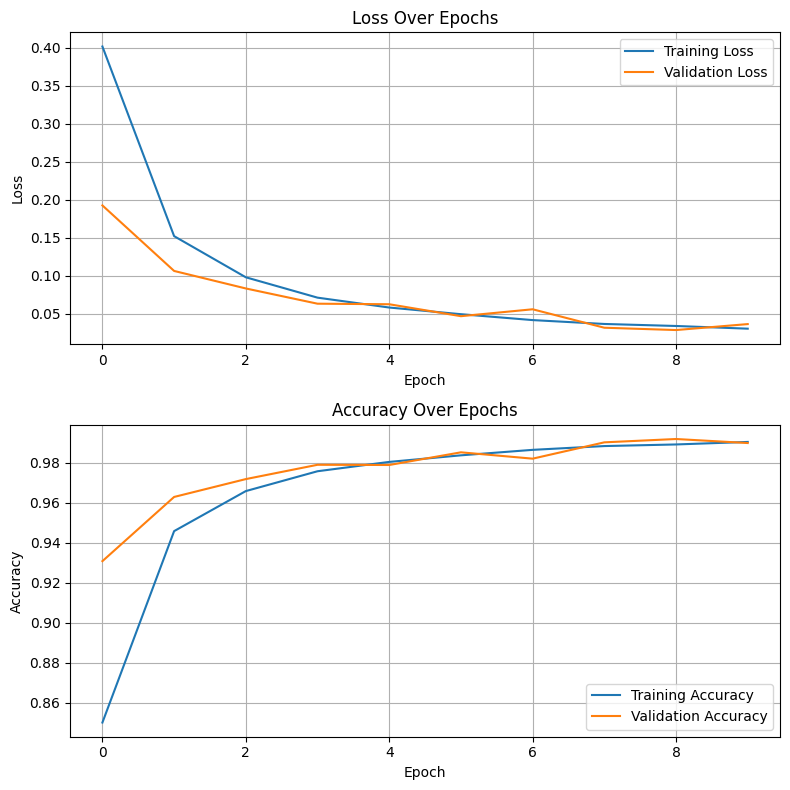

In [17]:
fig, axs = plt.subplots(2, figsize=(8, 8))

# Plot loss
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss Over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot accuracy
axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy Over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [18]:
train_score = model_cnn_bilstm.evaluate(x_train, y_train)
validation_score = model_cnn_bilstm.evaluate(x_val, y_val)

print('Accuracy Train data: ', train_score[1])
print('Accuracy Validation data: ', validation_score[1])

9059/9059 ━━━━━━━━━━━━━━━━━━━━ 89s 10ms/step - accuracy: 0.9912 - loss: 0.0296
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9901 - loss: 0.0354
Accuracy Train data:  0.9911757707595825
Accuracy Validation data:  0.9899408221244812


In [19]:
y_pred = model_cnn_bilstm.predict(x_test)

685/685 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step


In [20]:
from sklearn.metrics import classification_report

# Convert one-hot encoded labels to integer labels
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     18118
           1       0.67      0.82      0.74       556
           2       0.91      0.95      0.93      1448
           3       0.57      0.84      0.68       162
           4       0.96      0.98      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.82      0.91      0.86     21892
weighted avg       0.97      0.97      0.97     21892



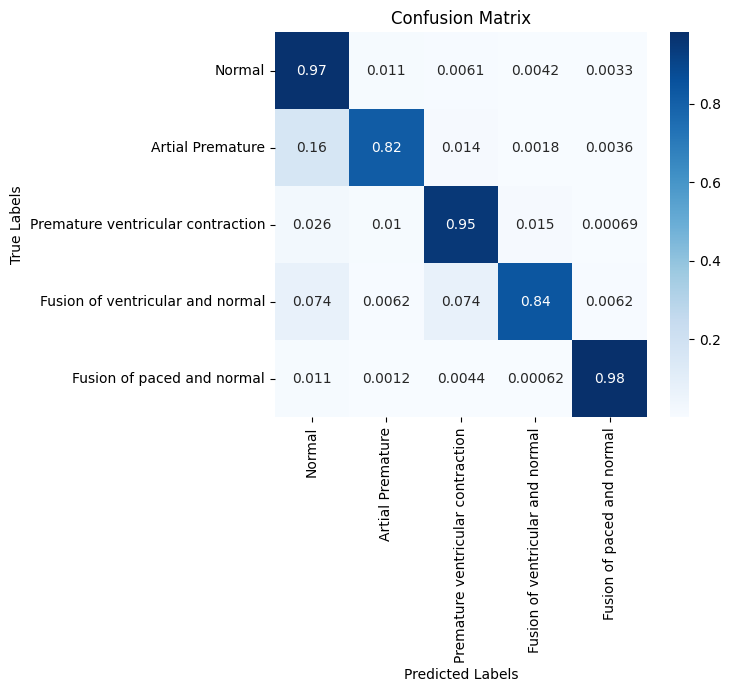

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, 
                      normalize='true')

labels = ['Normal', 'Artial Premature', 'Premature ventricular contraction', 'Fusion of ventricular and normal', 'Fusion of paced and normal']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [23]:
from tensorflow.keras.models import save_model

# Save the model
model_cnn_bilstm.save('best_model_save_bilstm.keras')